## Preprocess DataFrame and Handle Categorical Features for Clustering

Project Goal: Cluster users together to recommend songs.

This notebook focuses on preprocessing the `users_df` for clustering. The steps taken include:

*   **Handling Missing Values:** Rows with NaN values were dropped.
*   **Outlier Consideration and Scaling:** Instead of dropping users based on a play count cutoff, numerical features were scaled using `RobustScaler`, which is less sensitive to outliers than `MinMaxScaler` or `StandardScaler`. We did because we think there is value in knowing the preferred songs of power users.
*   **Categorical Feature Encoding:** We explored one-hot encoding for categorical features. Due to the high number of unique values in 'fav\_song' (over 119,000 unique values) and 'fav\_artist' (over 14,000 unique values), one-hot encoding both of these columns is not feasible due to memory constraints. We decided on only encoding 'fav\_artist'. We identified that 'fav\_maj\_genre' and 'fav\_min\_genre' have manageable unique values for one-hot encoding.

The preprocessed data, `users_df_encoded` (which includes our transformations), is now prepared for further analysis, such as dimensionality reduction with PCA and subsequent K-Means clustering. We save this processed df to our drive so that we can logically separate notebooks and not recompute.

### Load Data

In [ ]:
!pip install pyarrow  # to save data to a parquet file

In [ ]:
import pandas as pd
import sklearn as skl
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_df.csv"

In [ ]:
users_df = pd.read_csv(users_path)

### EDA and preprocessing
We thought we would drop outlier users but decided against it and went for a scaler that accounts for outliers. We include some of our EDA.

In [ ]:
users_df = users_df.dropna()

In [ ]:
users_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,964675.000000,9.646750e+05,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,9.646750e+05
mean,141.181386,3.513604e+04,49.295934,49.295934,16.997908,3.736872,2002.538344,7.581551,7.323604,16.915215,252.730078,4.243896e+03
std,187.844263,4.669391e+04,58.878465,58.878465,23.352253,4.710424,8.854614,7.557839,7.368206,30.218510,105.627814,7.971707e+03
min,10.000000,1.228089e+03,10.000000,10.000000,1.000000,1.000000,1924.000000,1.000000,1.000000,1.000000,0.522000,2.610000e+00
25%,36.000000,8.881068e+03,17.000000,17.000000,5.000000,1.000000,2001.000000,3.000000,2.000000,5.000000,200.097510,1.038522e+03
50%,77.000000,1.917234e+04,29.000000,29.000000,9.000000,2.000000,2006.000000,5.000000,5.000000,10.000000,235.911380,2.232525e+03
75%,171.000000,4.249473e+04,58.000000,58.000000,19.000000,4.000000,2008.000000,10.000000,10.000000,20.000000,280.998730,4.790950e+03
max,13132.000000,2.726693e+06,4400.000000,4400.000000,1630.000000,240.000000,2010.000000,356.000000,98.000000,9667.000000,3024.665670,1.948484e+06


<Axes: title={'center': 'total_play_count'}, ylabel='Frequency'>

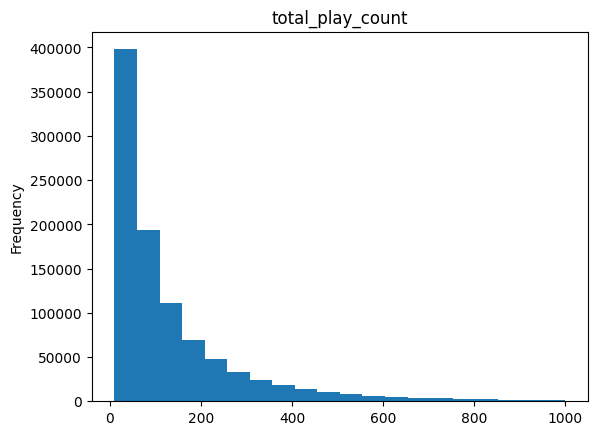

In [ ]:
users_df['total_play_count'].plot(
    kind='hist',
    bins=20,
    title='total_play_count',
    range=(10, 1000)  # min is 10
)

#### Scaling Numerical Features

After deciding not to drop users based on play count, we focused on scaling numerical features. We found `MinMaxScaler` was heavily influenced by outliers, compressing most data into a small range with a low mean. Based on scikit-learn documentation, we selected `RobustScaler` as it uses robust statistics (median and interquartile range) and is less sensitive to outliers, making it more suitable for our dataset.

In [ ]:
# Select numerical columns to normalize and standardize
numerical_cols = users_df.select_dtypes(include=['number']).columns

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# Apply minmax scaling
users_df_normalized = users_df.copy()
users_df_normalized[numerical_cols] = scaler_minmax.fit_transform(users_df_normalized[numerical_cols])

# Apply robust scaling
users_df_robustscaled = users_df.copy()
users_df_robustscaled[numerical_cols] = scaler_robust.fit_transform(users_df_robustscaled[numerical_cols])

print("Original Data:")
display(users_df[numerical_cols].describe())

print("MinMax Data:")
display(users_df_normalized[numerical_cols].describe())

print("Robust Scaled Data:")
display(users_df_robustscaled[numerical_cols].describe())

<>:19: SyntaxWarning: invalid escape sequence '\M'
<>:19: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-3918971373.py:19: SyntaxWarning: invalid escape sequence '\M'
  print("\MinMax Data:")


Original Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,964675.000000,9.646750e+05,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,9.646750e+05
mean,141.181386,3.513604e+04,49.295934,49.295934,16.997908,3.736872,2002.538344,7.581551,7.323604,16.915215,252.730078,4.243896e+03
std,187.844263,4.669391e+04,58.878465,58.878465,23.352253,4.710424,8.854614,7.557839,7.368206,30.218510,105.627814,7.971707e+03
min,10.000000,1.228089e+03,10.000000,10.000000,1.000000,1.000000,1924.000000,1.000000,1.000000,1.000000,0.522000,2.610000e+00
25%,36.000000,8.881068e+03,17.000000,17.000000,5.000000,1.000000,2001.000000,3.000000,2.000000,5.000000,200.097510,1.038522e+03
50%,77.000000,1.917234e+04,29.000000,29.000000,9.000000,2.000000,2006.000000,5.000000,5.000000,10.000000,235.911380,2.232525e+03
75%,171.000000,4.249473e+04,58.000000,58.000000,19.000000,4.000000,2008.000000,10.000000,10.000000,20.000000,280.998730,4.790950e+03
max,13132.000000,2.726693e+06,4400.000000,4400.000000,1630.000000,240.000000,2010.000000,356.000000,98.000000,9667.000000,3024.665670,1.948484e+06


\MinMax Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000
mean,0.009997,0.012441,0.008951,0.008951,0.009821,0.011451,0.913237,0.018540,0.065192,0.001647,0.083398,0.002177
std,0.014315,0.017132,0.013412,0.013412,0.014335,0.019709,0.102961,0.021290,0.075961,0.003126,0.034928,0.004091
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001981,0.002808,0.001595,0.001595,0.002455,0.000000,0.895349,0.005634,0.010309,0.000414,0.065994,0.000532
50%,0.005106,0.006584,0.004328,0.004328,0.004911,0.004184,0.953488,0.011268,0.041237,0.000931,0.077837,0.001144
75%,0.012269,0.015141,0.010934,0.010934,0.011050,0.012552,0.976744,0.025352,0.092784,0.001966,0.092746,0.002457
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Robust Scaled Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000,964675.000000
mean,0.475418,0.474917,0.495023,0.495023,0.571279,0.578957,-0.494522,0.368793,0.290451,0.461014,0.207892,0.536019
std,1.391439,1.389135,1.436060,1.436060,1.668018,1.570141,1.264945,1.079691,0.921026,2.014567,1.305639,2.124413
min,-0.496296,-0.533838,-0.463415,-0.463415,-0.571429,-0.333333,-11.714286,-0.571429,-0.500000,-0.600000,-2.909590,-0.594259
25%,-0.303704,-0.306163,-0.292683,-0.292683,-0.285714,-0.333333,-0.714286,-0.285714,-0.375000,-0.333333,-0.442686,-0.318195
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.696296,0.693837,0.707317,0.707317,0.714286,0.666667,0.285714,0.714286,0.625000,0.666667,0.557314,0.681805
max,96.703704,80.548205,106.609756,106.609756,115.785714,79.333333,0.571429,50.142857,11.625000,643.800000,34.471103,518.664642


One hot encode categorical data

The number of unique favorite arists: 14,975. This is manageable.

The number of unique favorite songs is 119,417. This takes too much RAM.

In [ ]:
# Count unique categorical values
num_unique_artists = users_df['fav_artist'].nunique()
num_unique_songs = users_df['fav_song'].nunique()  # too many
num_unique_maj_genres = users_df['fav_maj_genre'].nunique()
num_unique_min_genres = users_df['fav_min_genre'].nunique()

print(f"Number of unique favorite artists: {num_unique_artists}")
print(f"Number of unique favorite songs: {num_unique_songs}")
print(f"Number of unique favorite major genres: {num_unique_maj_genres}")
print(f"Number of unique favorite minority genres: {num_unique_min_genres}")

Number of unique favorite artists: 14975
Number of unique favorite songs: 119417
Number of unique favorite major genres: 15
Number of unique favorite minority genres: 15


In [ ]:
# Select categorical columns for one-hot encoding
# ['fav_song'] a ton of these guys = run out of ram if try to use so omit
users_df_robustscaled = users_df_robustscaled.drop(columns=["fav_song"])
# Features to do one-hot encoding on
categorical_cols = ['fav_maj_genre', 'fav_min_genre', 'fav_artist']
users_df_encoded = pd.get_dummies(users_df_robustscaled, columns=categorical_cols, dummy_na=False)

print("Original DataFrame shape:", users_df_robustscaled.shape)
print("DataFrame shape after one-hot encoding:", users_df_encoded.shape)
display(users_df_encoded.head())

Original DataFrame shape: (964675, 16)
DataFrame shape after one-hot encoding: (964675, 15018)


,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,...,fav_artist_ARZYT8C1187FB4D57F,fav_artist_ARZYZUU11F4C841DCC,fav_artist_ARZZ1201187B9AFA16,fav_artist_ARZZ5ZR1187FB4D149,fav_artist_ARZZLLI1187B99C8DD,fav_artist_ARZZMTX119B340377D,fav_artist_ARZZMWO1187B9AFB36,fav_artist_ARZZQZQ12509411C96,fav_artist_ARZZRK91187B9A5CA5,fav_artist_ARZZXT51187FB4627E
0,00000b722001882066dff9d2da8a775658053ea0,-0.474074,-0.475015,-0.414634,-0.414634,-0.571429,-0.333333,-0.285714,-0.428571,-0.375,...,False,False,False,False,False,False,False,False,False,False
1,00001638d6189236866af9bbf309ae6c2347ffdc,-0.155556,-0.161941,-0.365854,-0.365854,-0.428571,-0.333333,0.142857,-0.285714,-0.375,...,False,False,False,False,False,False,False,False,False,False
2,0000175652312d12576d9e6b84f600caa24c4715,-0.429630,-0.467792,-0.414634,-0.414634,-0.500000,-0.333333,-5.714286,-0.571429,-0.375,...,False,False,False,False,False,False,False,False,False,False
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,-0.385185,-0.388847,-0.268293,-0.268293,0.071429,0.333333,0.428571,0.428571,0.250,...,False,False,False,False,False,False,False,False,False,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,-0.370370,-0.340686,-0.097561,-0.097561,0.428571,1.000000,0.000000,0.142857,-0.375,...,False,False,False,False,False,False,False,False,False,False


### Save processed dataframe

In [ ]:
# Define the path to save the processed dataframe
processed_users_path_parquet = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_df_encoded.parquet"
# Save the processed dataframe to Parquet
users_df_encoded.to_parquet(processed_users_path_parquet, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {processed_users_path_parquet}")

Processed DataFrame saved to: /content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_df_encoded.parquet
